# Project 1

## by Dion Ho


# Import Python Libraries

In [1]:
import numpy as np #Note that numpy-1.16.2 is needed
import math
import scipy.sparse as sp
import time
from scipy.integrate import quad
from scipy import linalg as la
from math import pi
from math import factorial
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

In [2]:
def rangeE(start,end):
    return range(start,end+1)

## Problem 1

In [3]:
def L(xvals,kk,x):
    value = np.ones(x.size)
    n = xvals.size
    for ii in range(0,n):
        if ii != kk:
            value *= (x-xvals[ii])/(xvals[kk]-xvals[ii])
    return value
    
def p_Lagrange(xvals,yvals,x):
    n = yvals.size
    pLagrange = np.zeros(x.size)
    for kk in range(0,n):
        pLagrange += yvals[kk]*L(xvals,kk,x)
    return pLagrange

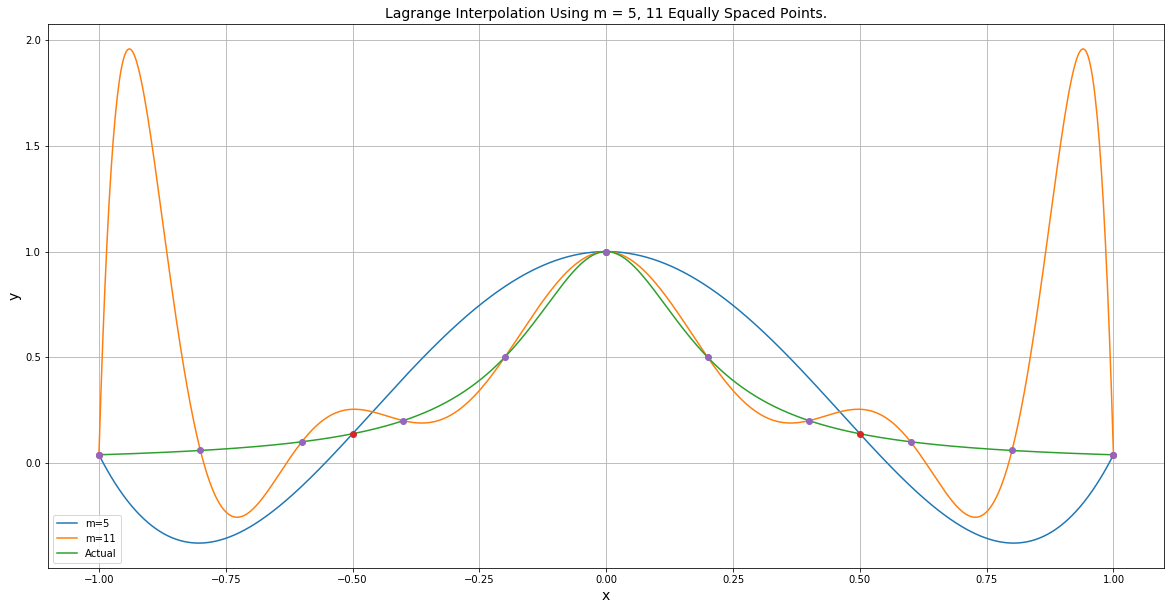

In [4]:
f = lambda x: 1/(1+25*x**2)
x = np.linspace(-1,1,1000)

m = 5
x5vals = np.linspace(-1,1,m)
y5vals = f(x5vals)
m5 = p_Lagrange(x5vals,y5vals,x)

m = 11
x11vals = np.linspace(-1,1,m)
y11vals = f(x11vals)
m11 = p_Lagrange(x11vals,y11vals,x)

plt.figure(figsize=(20,10))
plt.title("Lagrange Interpolation Using m = 5, 11 Equally Spaced Points.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.plot(x,m5)
plt.plot(x,m11)
plt.plot(x,f(x))
plt.plot(x5vals,y5vals, "o")
plt.plot(x11vals,y11vals, "o")
plt.legend(["m=5","m=11","Actual"])
plt.grid()

This plot shows the Lagrange Interpolation of Runge's function for $m = 5, 11$ equispaced points (labelled in red and purple respectively). The plot clearly demonstrates Runge's phenomenon with extreme oscillations between interpolation points at the extreme ends of each graph (see the orange graph between the two leftmost or rightmost purple points for example). These oscillations contribute to the high interpolation error.

## Problem 2

In [5]:
def Bweights(xvals):
    n = xvals.size
    value = np.empty(n) #Initialising an array as np.empty is faster.
    C = (np.max(xvals) - np.min(xvals)) / 4
    shuffle = np.random.permutation(n-1)
    for ii in range(0,n):
        temp = (xvals[ii] - np.delete(xvals, ii)) / C
        temp = temp[shuffle]
        value[ii] = 1/np.product(temp)
    return value
    
def p_Barycentric(xvals,yvals,x):
    wherezeros = np.array([], dtype = "int")
    replacement = np.array([])
    n = yvals.size
    xsize = x.size
    numer = np.zeros(xsize)
    denom = np.zeros(xsize)
    w = Bweights(xvals)
    for jj in range(0,n):
        d = (x - xvals[jj])
        
        z = np.where(np.abs(d)<1e-14)[0] #The following block of code deals with the divisions by zero.
        if len(z) != 0:
            wherezeros = np.append(wherezeros,z)
            replacement = np.append(replacement,yvals[jj])
            x = np.delete(x,z)
            d = np.delete(d,z)
            numer = np.delete(numer,z)
            denom = np.delete(denom,z)
        
        numer += (w[jj]*yvals[jj])/d
        denom += (w[jj])/d
    ans = numer/denom
    ans = np.insert(ans,wherezeros,replacement)
    return ans

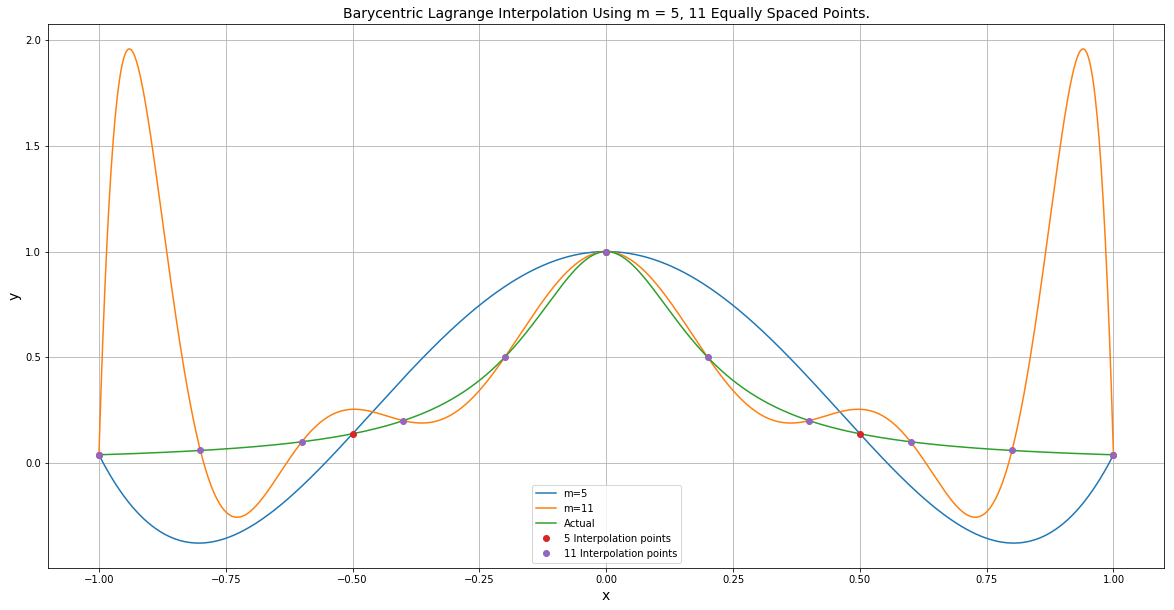

In [6]:
f = lambda x: 1/(1+25*x**2)
x = np.linspace(-1,1,1000)

m = 5
x5vals = np.linspace(-1,1,m)
y5vals = f(x5vals)
m5 = p_Barycentric(x5vals,y5vals,x)

m = 11
x11vals = np.linspace(-1,1,m)
y11vals = f(x11vals)
m11 = p_Barycentric(x11vals,y11vals,x)

plt.figure(figsize=(20,10))
plt.title("Barycentric Lagrange Interpolation Using m = 5, 11 Equally Spaced Points.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.plot(x,m5)
plt.plot(x,m11)
plt.plot(x,f(x))
plt.plot(x5vals,y5vals, "o")
plt.plot(x11vals,y11vals, "o")
plt.legend(["m=5","m=11","Actual","5 Interpolation points", "11 Interpolation points"])
plt.grid()

Barycentric Lagrange Interpolation results in identical graphs to those produce by standard Lagrange Interpolation (with the same Runge phenomenon). In fact, the interpolating polynomial is unique for a certain set of points.

## Problem 3

In [7]:
def Bweights(xvals):
    n = xvals.size
    value = np.empty(n)
    C = (np.max(xvals) - np.min(xvals)) / 4
    shuffle = np.random.permutation(n-1)
    for ii in range(0,n):
        temp = (xvals[ii] - np.delete(xvals, ii)) / C
        temp = temp[shuffle]
        value[ii] = 1/np.product(temp)
    return value

def update_Bweights(old_xvals,old_weights,new_xvals):
    n = new_xvals.size
    for ii in range(0,n):
        newxval = new_xvals[ii]
        new_weight = 1/np.product(newxval - old_xvals)
        old_weights /= (old_xvals - newxval)
        old_weights = np.append(new_weight,old_weights)
        old_xvals = np.append(newxval,old_xvals)
    return old_weights

def p_Barycentric_reuse(xvals,yvals,x,old_data=np.array([[],[],[]])):
    #old_data must be in the format: np.array([[old_xvals],[old_yvals],[old_weights]])
    old_xvals = old_data[0,:]
    u1,u2,cup = np.intersect1d(old_xvals,xvals,assume_unique=True,return_indices=True) #Note that numpy-1.16.2 is needed for "return_indices" to work.
    xvals = np.delete(xvals,cup)
    yvals = np.delete(yvals,cup) #We remove any intersection to prevent divisions by zero when updating the weights.
    wherezeros = np.array([], dtype = "int")
    replacement = np.array([])
    yvals = np.append(yvals,old_data[1,:])
    n = yvals.size
    xsize = x.size
    numer = np.zeros(xsize)
    denom = np.zeros(xsize)
    w = update_Bweights(old_xvals,old_data[2,:],xvals)
    xvals = np.append(xvals,old_xvals)
    for jj in range(0,n):
        d = (x - xvals[jj])
        
        z = np.where(np.abs(d)<1e-14)[0] #The following block of code deals with the divisions by zero.
        if len(z) != 0:
            wherezeros = np.append(wherezeros,z)
            replacement = np.append(replacement,yvals[jj])
            x = np.delete(x,z)
            d = np.delete(d,z)
            numer = np.delete(numer,z)
            denom = np.delete(denom,z)
        
        numer += (w[jj]*yvals[jj])/d
        denom += (w[jj])/d
    ans = numer/denom
    ans = np.insert(ans,wherezeros,replacement)
    old_data = np.array([xvals,yvals,w])
    return ans, old_data

Data which can be re-used from m = 5
[[-1.         -0.5         0.          0.5         1.        ]
 [ 0.03846154  0.13793103  1.          0.13793103  0.03846154]
 [ 0.66666667 -2.66666667  4.         -2.66666667  0.66666667]]

Data which can be re-used from m = 9
[[-7.50000000e-01 -2.50000000e-01  2.50000000e-01  7.50000000e-01
  -1.00000000e+00 -5.00000000e-01  0.00000000e+00  5.00000000e-01
   1.00000000e+00]
 [ 6.63900415e-02  3.90243902e-01  3.90243902e-01  6.63900415e-02
   3.84615385e-02  1.37931034e-01  1.00000000e+00  1.37931034e-01
   3.84615385e-02]
 [-1.30031746e+01 -9.10222222e+01 -9.10222222e+01 -1.30031746e+01
   1.62539683e+00  4.55111111e+01  1.13777778e+02  4.55111111e+01
   1.62539683e+00]]


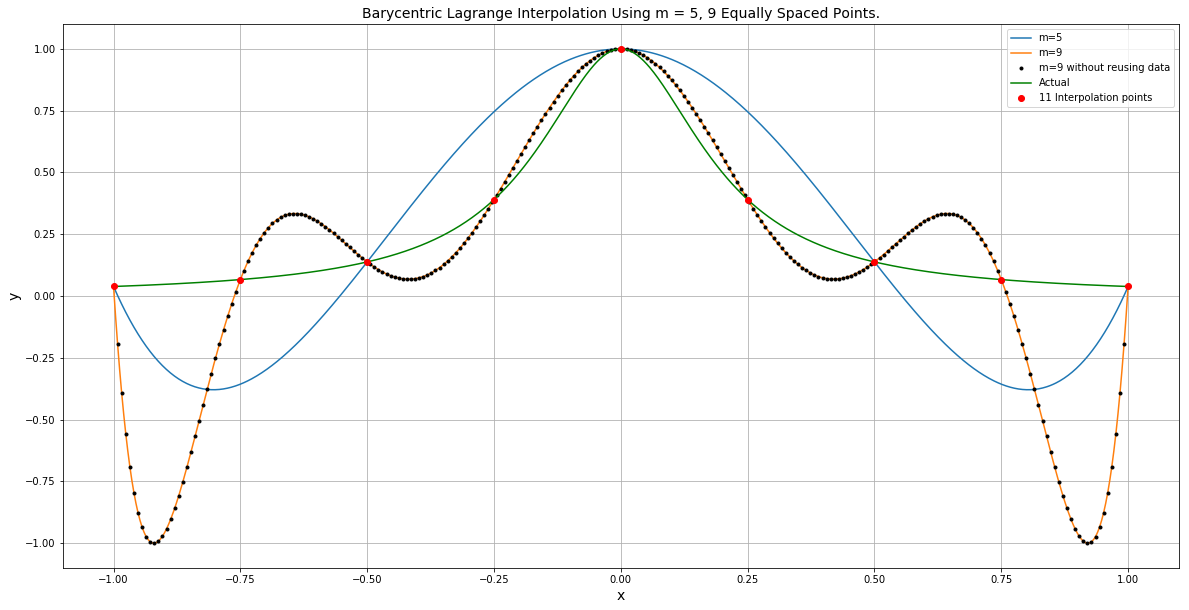

In [8]:
f = lambda x: 1/(1+25*x**2)
x = np.linspace(-1,1,1000)

m = 5
x5vals = np.linspace(-1,1,m)
y5vals = f(x5vals)
m5, old_data_m5 = p_Barycentric_reuse(x5vals,y5vals,x)
print("Data which can be re-used from m =",m)
print(old_data_m5)
print()

m = 9
x9vals = np.linspace(-1,1,m)
y9vals = f(x9vals)
m9, old_data_m9 = p_Barycentric_reuse(x9vals,y9vals,x,old_data_m5)
print("Data which can be re-used from m =",m)
print(old_data_m9)
x1 = np.linspace(-1,1,250)
m9_2 = p_Barycentric(x9vals,y9vals,x1)

plt.figure(figsize=(20,10))
plt.title("Barycentric Lagrange Interpolation Using m = 5, 9 Equally Spaced Points.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.plot(x,m5)
plt.plot(x,m9)
plt.plot(x1,m9_2, ".",color="black")
plt.plot(x,f(x),color="green")
plt.plot(x9vals,y9vals, "o", color="red")
plt.legend(["m=5","m=9","m=9 without reusing data","Actual","11 Interpolation points"])
plt.grid()

We implemented the function "p_Barycentric_reuse" which outputs both the y-values of the interpolation polynomial and a matrix containing all the data which can be re-used in another polynomial which shares some of the interpolation points of the original polynomial. "p_Barycentric_reuse" accepts and will use data from a previous interpolation that is passed into it, though if no data was passed than the function will just calculate every weight from scratch. 

As a "sanity check", we checked that the polynomial formed by re-using data is identical to the polynomial formed without re-using data.

## Problem 4

### Scipy's Barycentric Interpolator (Results compared to those attained for Problem 1)

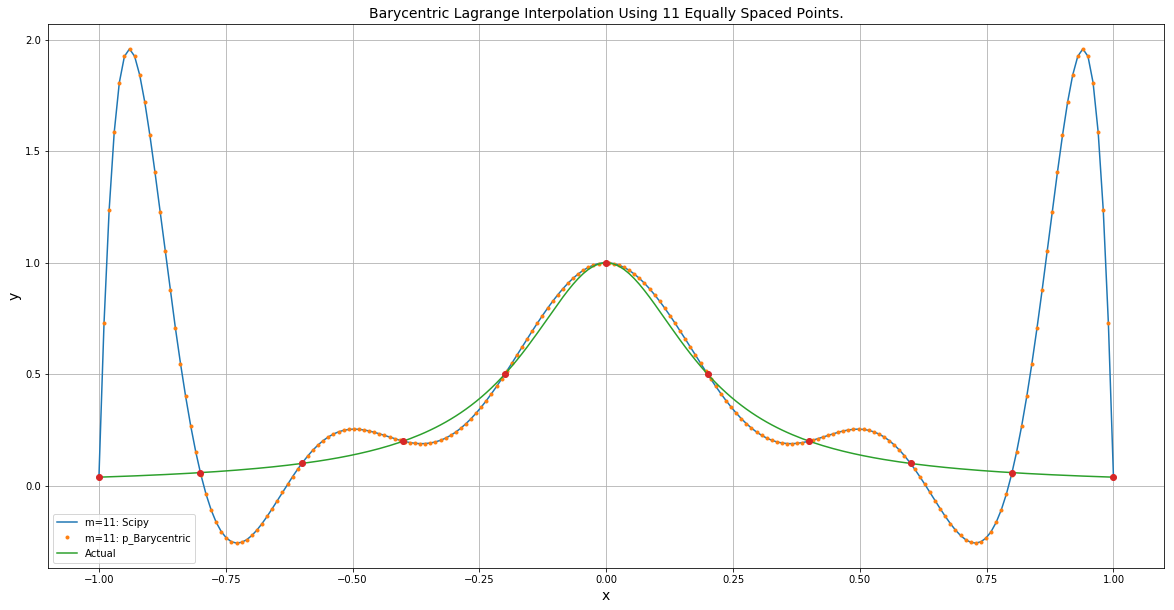

In [9]:
from scipy.interpolate import BarycentricInterpolator
f = lambda x: 1/(1+25 * x**2) # Function to be interpolated.
# Obtain the Chebyshev extremal points on [-1,1].
n = 11
pts = np.linspace(-1, 1, n)
domain = np.linspace(-1, 1, 200)
poly = BarycentricInterpolator(pts[:-1])
poly.add_xi(np.array([pts[-1]])) # Oops, forgot one of the points.
poly.set_yi(f(pts)) # Set the y values.
plt.figure(figsize=(20,10))
plt.plot(domain, poly.__call__(domain))
plt.plot(domain, p_Barycentric(pts,f(pts),domain),'.')
plt.plot(domain, f(domain))
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.title("Barycentric Lagrange Interpolation Using 11 Equally Spaced Points.", fontsize = 14)
plt.plot(pts,f(pts), "o")
plt.legend(["m=11: Scipy","m=11: p_Barycentric","Actual"])
plt.grid()

Here, we compare our implementation of the Barycentric Lagrange Interpolation with Scipy's implementation. Indeed, our implementation returns identical values as Scipy's implementation.

### Function to generate either Equispaced or Chebyshev interpolating points (will be used in the remaining questions)

In [10]:
def chebspace(N,m=-1,M=1,Zero=False): #Returns N Chebyshev Extremum (Default) or Zero points in the specified interval (Default is [-1,1]).
    r = (m + M)/2
    if (Zero == True):
        pts = np.cos((np.array(range(N,0,-1)) - 0.5)*np.pi/N)
    else:
        pts = np.cos(np.array(range(N-1,-1,-1))*np.pi/(N-1))
    return (pts*(M - r) + r)

### Error and Runtime functions

In [11]:
def InterpolErr(f,n,x_N = 200,lin=False): #Default: 200 point domain and use Cheb nodes.
    if lin == True:
        xvals = np.linspace(-1,1,2**n + 1)
    else:
        xvals = chebspace(2**n + 1)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    poly = BarycentricInterpolator(xvals,yvals)
    return np.linalg.norm((p_Lagrange(xvals,yvals,x) - y), ord=np.inf), np.linalg.norm((p_Barycentric(xvals,yvals,x) - y), ord=np.inf), np.linalg.norm((poly.__call__(x) - y), ord=np.inf)

def InterpolTime(f,n,x_N = 200,lin=False, trials = 100): #Default: 200 point domain, use Cheb nodes, and perform 100 time trials.
    if lin == True:
        xvals = np.linspace(-1,1,2**n + 1)
    else:
        xvals = chebspace(2**n + 1)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    avg1,avg2,avg3 = 0,0,0
    for jj in range(0,trials):
        start_time = time.time()
        p_Lagrange(xvals,yvals,x)
        end_time = time.time()
        avg1+=(end_time-start_time)
        
        start_time = time.time()
        p_Barycentric(xvals,yvals,x)
        end_time = time.time()
        avg2+=(end_time-start_time)
        
        start_time = time.time()
        poly = BarycentricInterpolator(xvals,yvals)
        poly.__call__(x) - y
        end_time = time.time()
        avg3+=(end_time-start_time)
    return avg1/trials, avg2/trials, avg3/trials

### Error measurements

In [12]:
n = 7 #Use 2^n + 1 nodes.
f = lambda x: 1/(1+25 * x**2)

LErr, BErr, ScBErr = InterpolErr(f,n)
print("Norm-inf Error of Lagrange Interpolation")
print(LErr)
print("Norm-inf Error of Barycentric Interpolation")
print(BErr)
print("Norm-inf Error of Scipy's Barycentric Interpolation")
print(ScBErr)

Norm-inf Error of Lagrange Interpolation
8.558431741079175e-12
Norm-inf Error of Barycentric Interpolation
8.558376229927944e-12
Norm-inf Error of Scipy's Barycentric Interpolation
8.558320718776713e-12


The errors are about the same for all three. This is to be expected, as the latter two implementations should be equivalent and theoretically, Lagrange Interpolation and Barycentric Interpolation should return the same interpolating polynomial.

### Runtime measurements 1: Recalculate every weight each time

In [13]:
n = 5 #Use 2^n +1 nodes; be careful, using toomany nodes may result in overflow.
f = lambda x: 1/(1+25 * x**2)

LTime, BTime, ScBTime = InterpolTime(f,n)
print("Runtime of Lagrange Interpolation")
print(LTime)
print()
print("Runtime of Barycentric Interpolation")
print(BTime)
print()
print("Runtime of Scipy's Barycentric Interpolation")
print(ScBTime)

Runtime of Lagrange Interpolation
0.005363945960998535

Runtime of Barycentric Interpolation
0.0014866805076599121

Runtime of Scipy's Barycentric Interpolation
0.0004695558547973633


Scipy's Barycentric Interpolation is the fastest followed by p_Barycentric followed by p_Lagrange. This is in line with the theory. Ignoring Scipy since it has been optimised to a far greater degree than the other two functions, the theoretical advantage of Barycentric Interpolation over Lagrange Interpolation is the former's speed; both methods result in the same interpolating polynomial.

### Runtime measurements 2: All weights precalculated

In [14]:
def InterpolTime_reuseW(f,n,x_N = 200,lin=False, trials = 100): #Default: 200 point domain, use Cheb nodes, and perform 100 time trials.
    if lin == True:
        xvals = np.linspace(-1,1,2**n + 1)
    else:
        xvals = chebspace(2**n + 1)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    u, OldData = p_Barycentric_reuse(xvals,yvals,x)
    poly = BarycentricInterpolator(xvals,yvals)
    avg1,avg2,avg3 = 0,0,0
    for jj in range(0,trials):
        start_time = time.time()
        p_Lagrange(xvals,yvals,x)
        end_time = time.time()
        avg1+=(end_time-start_time)
        
        start_time = time.time()
        p_Barycentric_reuse(xvals,yvals,x,OldData)
        end_time = time.time()
        avg2+=(end_time-start_time)
        
        start_time = time.time()
        poly.__call__(x) - y
        end_time = time.time()
        avg3+=(end_time-start_time)
    return avg1/trials, avg2/trials, avg3/trials

In [15]:
n = 5 #Use 2^n + 1 nodes.
f = lambda x: 1/(1+25 * x**2)

LTime2, BTime2, ScBTime2 = InterpolTime_reuseW(f,n)
print("Runtime of Lagrange Interpolation")
print(LTime2)
print("Percentage change from measurement 1 =", (LTime2 - LTime)*100/LTime)
print()
print("Runtime of Barycentric Interpolation")
print(BTime2)
print("Percentage change from measurement 1 =", (BTime2 - BTime)*100/BTime)
print()
print("Runtime of Scipy's Barycentric Interpolation")
print(ScBTime2)
print("Percentage change from measurement 1 =", (ScBTime2 - ScBTime)*100/ScBTime)

Runtime of Lagrange Interpolation
0.005344994068145752
Percentage change from measurement 1 = -0.35331998104722817

Runtime of Barycentric Interpolation
0.0006892681121826172
Percentage change from measurement 1 = -53.63710571092711

Runtime of Scipy's Barycentric Interpolation
0.00017931699752807618
Percentage change from measurement 1 = -61.81135945893797


As would be expected from the theory, Scipy's Barycentric Interpolation and p_Barycentric are now significantly faster. The "percentage change from measurement 1" output for both Barycentric interpolation functions should be around -50%, i.e. they are about 50% faster. The percentage change of the Lagrange Interpolation function provides an indication of the variance; the percentage decrease in time for the Barycentric interpolation functions should be significant.

### Runtime measurements 3: Half of the weights precalculated

In [16]:
def InterpolTime_reusehW(f,n,x_N = 200,lin=False, trials = 100): #Default: 200 point domain, use Cheb nodes, and perform 100 time trials.
    if lin == True:
        xvals, xvals2 = np.linspace(-1,1,2**n + 1), np.linspace(-1,1,2**(n-1) + 1)
    else:
        xvals, xvals2 = chebspace(2**n + 1), chebspace(2**(n-1) + 1)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    u, OldData = p_Barycentric_reuse(xvals2,f(xvals2),x)
    poly = BarycentricInterpolator(xvals2)
    u1,u2,cup = np.intersect1d(xvals2,xvals,assume_unique=True,return_indices=True) #Note that numpy-1.16.2 is needed for "return_indices" to work.
    xvals_new = np.delete(xvals,cup)
    avg1,avg2,avg3 = 0,0,0
    for jj in range(0,trials):
        start_time = time.time()
        p_Lagrange(xvals,yvals,x)
        end_time = time.time()
        avg1+=(end_time-start_time)
        
        start_time = time.time()
        p_Barycentric_reuse(xvals,yvals,x,OldData)
        end_time = time.time()
        avg2+=(end_time-start_time)
        
        start_time = time.time()
        poly.add_xi(xvals_new)
        poly.set_yi(yvals)
        poly.__call__(x) - y
        end_time = time.time()
        poly = BarycentricInterpolator(xvals2)
        avg3+=(end_time-start_time)
    return avg1/trials, avg2/trials, avg3/trials

In [17]:
n = 5 #Use 2^n + 1 nodes.
f = lambda x: 1/(1+25 * x**2)

LTime3, BTime3, ScBTime3 = InterpolTime_reusehW(f,n)
print("Runtime of Lagrange Interpolation")
print(LTime3)
print("Percentage change from measurement 1 =", (LTime3 - LTime)*100/LTime)
print()
print("Runtime of Barycentric Interpolation")
print(BTime3)
print("Percentage change from measurement 1 =", (BTime3 - BTime)*100/BTime)
print()
print("Runtime of Scipy's Barycentric Interpolation")
print(ScBTime3)
print("Percentage change from measurement 1 =", (ScBTime3 - ScBTime)*100/ScBTime)

Runtime of Lagrange Interpolation
0.005267050266265869
Percentage change from measurement 1 = -1.8064256321222927

Runtime of Barycentric Interpolation
0.0010172247886657715
Percentage change from measurement 1 = -31.57744495709307

Runtime of Scipy's Barycentric Interpolation
0.00033829212188720705
Percentage change from measurement 1 = -27.954870878311816


Naturally, Scipy's Barycentric Interpolation and p_Barycentric are now slower than when all the weights were precalculated, however, they are still significantly faster than when every weight was recalculated each time. This is shown by the "Percentage change from measurement 1" output for both Barycentric Interpolation functions.

## Problem 5

In [18]:
def InterpolErr_ScB(f,n,x_N = 400,lin=False): #Default: 400 point domain and use Cheb extremal nodes.
    if lin == True:
        xvals = np.linspace(-1,1,2**n)
    else:
        xvals = chebspace(2**n)
    x = np.linspace(-1,1,x_N)
    yvals = f(xvals)
    y = f(x)
    poly = BarycentricInterpolator(xvals,yvals)
    return np.linalg.norm((poly.__call__(x) - y), ord=np.inf)

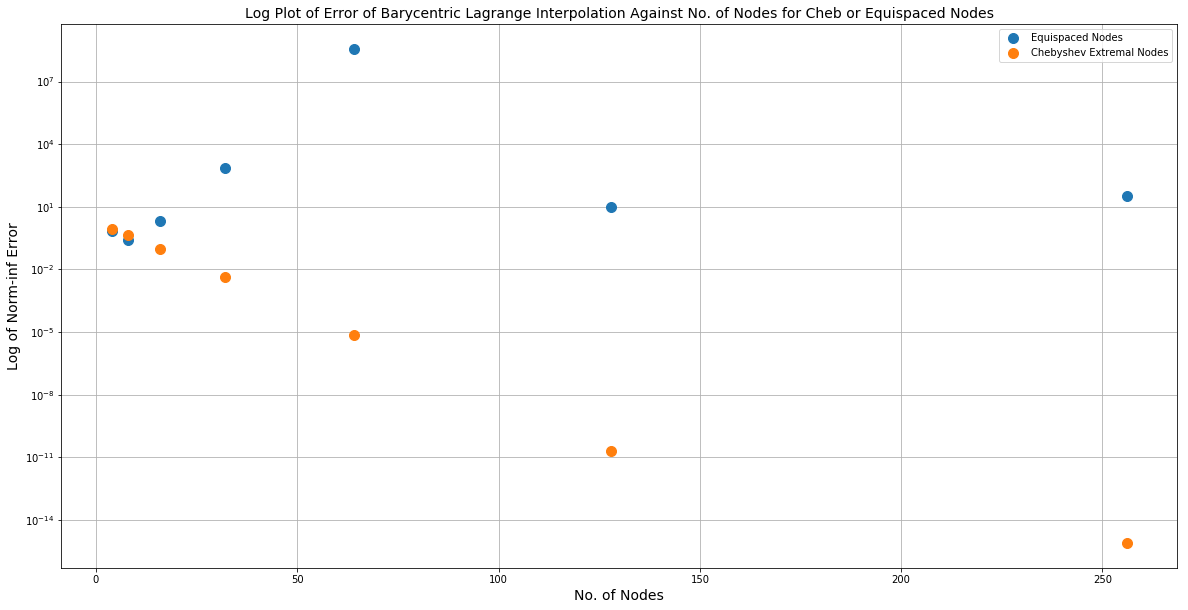

In [19]:
Mx = 8
Mn = 2
f = lambda x: 1/(1+25 * x**2)
linval = np.empty(Mx - Mn + 1)
chebval = np.empty(Mx - Mn + 1)
x = np.empty(Mx - Mn + 1)

for n in rangeE(Mn,Mx): #Use 2^n nodes.
    linval[n-2] = InterpolErr_ScB(f,n,lin=True)
    chebval[n-2] = InterpolErr_ScB(f,n,lin=False)
    x[n-2] = 2**n

plt.figure(figsize=(20,10))
plt.semilogy(x, linval, 'o', MarkerSize = 10)
plt.semilogy(x, chebval, 'o', MarkerSize = 10)
plt.xlabel("No. of Nodes", fontsize = 14)
plt.ylabel("Log of Norm-inf Error", fontsize = 14)
plt.title("Log Plot of Error of Barycentric Lagrange Interpolation Against No. of Nodes for Cheb or Equispaced Nodes", fontsize = 14)
plt.legend(["Equispaced Nodes","Chebyshev Extremal Nodes"])
plt.grid()

As indicated by the plot, only for Chebyshev nodes does the error of the interpolation decreases as the number of nodes increases. When equispaced nodes are used, the error may actually increase when the number of nodes is increased. Using Chebyshev nodes, about 250 nodes are required for machine precision.

We will plot the function for $n = 2^6, 2^7, 2^8$.

### Function Plots

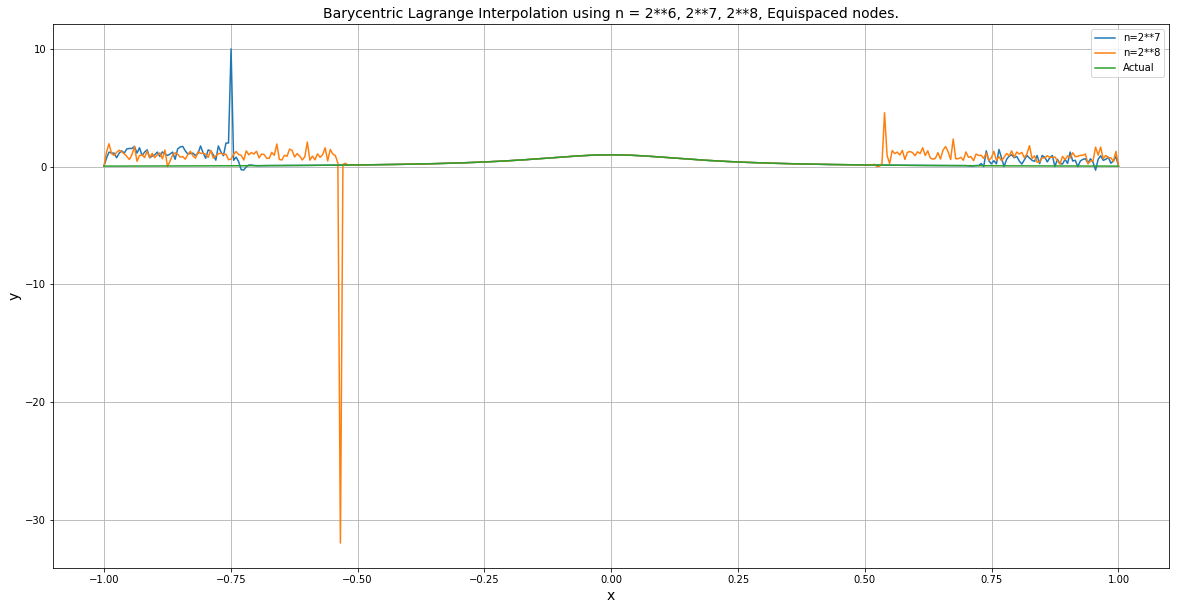

In [20]:
f = lambda x: 1/(1+25*x**2)
x = np.linspace(-1,1,400)

n = 6
x6lin = np.linspace(-1,1,2**n)
x6cheb = chebspace(2**n)

n = 7
x7lin = np.linspace(-1,1,2**n)
x7cheb = chebspace(2**n)

n = 8
x8lin = np.linspace(-1,1,2**n)
x8cheb = chebspace(2**n)

plt.figure(figsize=(20,10))
plt.title("Barycentric Lagrange Interpolation using n = 2**6, 2**7, 2**8, Equispaced nodes.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
#plt.plot(x,BarycentricInterpolator(x6lin,f(x6lin)).__call__(x)) #The error for n = 2**6 is too atrociously bad.
plt.plot(x,BarycentricInterpolator(x7lin,f(x7lin)).__call__(x))
plt.plot(x,BarycentricInterpolator(x8lin,f(x8lin)).__call__(x))
plt.plot(x,f(x))
plt.legend(["n=2**7","n=2**8","Actual"])
plt.grid()
#Looking at the graphs, it is certainly believable that the error is in the hundreds, as was indicated in the Log Error Plot.

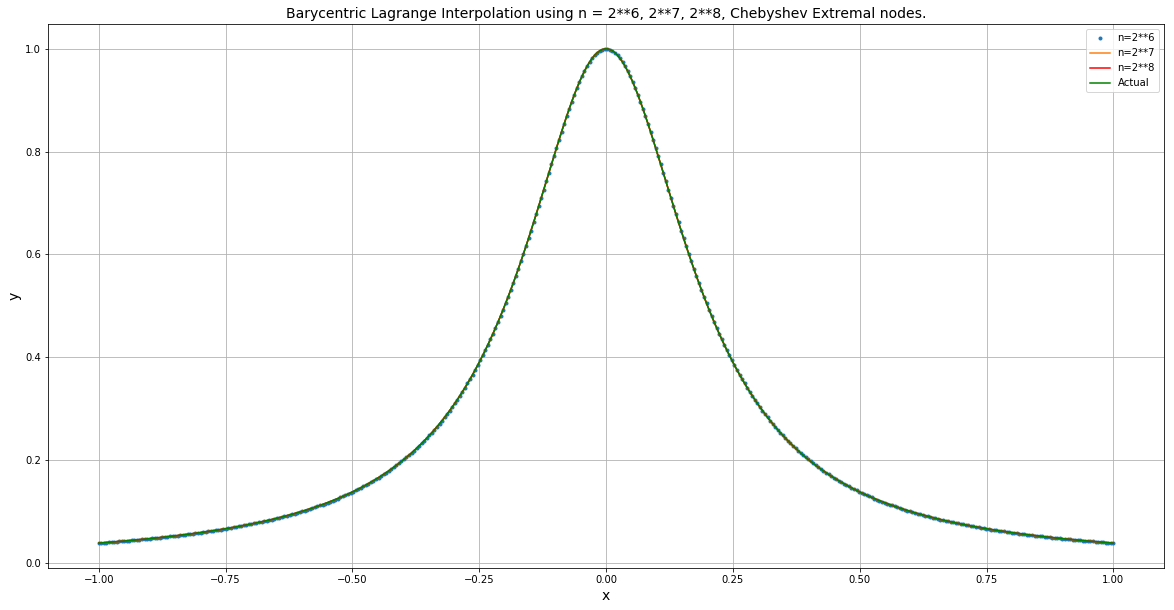

In [21]:
plt.figure(figsize=(20,10))
plt.title("Barycentric Lagrange Interpolation using n = 2**6, 2**7, 2**8, Chebyshev Extremal nodes.", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("y", fontsize = 14)
plt.plot(x,BarycentricInterpolator(x6cheb,f(x6cheb)).__call__(x),".")
plt.plot(x,BarycentricInterpolator(x7cheb,f(x7cheb)).__call__(x))
plt.plot(x,BarycentricInterpolator(x8cheb,f(x8cheb)).__call__(x),color="red")
plt.plot(x,f(x),color="green")
plt.legend(["n=2**6","n=2**7","n=2**8","Actual"])
plt.grid()
#The interpolations are almost perfect! All the graphs overlap seemingly perfectly.

## Problem 6

In [22]:
def Cheb(f,n):
    y = chebspace(n+1)
    farray = f(y)
    fstack = np.hstack([farray,farray[-2:0:-1]])
    ans = np.real(np.fft.fft(fstack)/(n))[0:n+1]*(-1)**np.array(range(0,n+1))
    ans[0] = ans[0]/2
    ans[n] = ans[n]/2
    return ans

### Validation of Cheb function with the function np.polynomial.chebyshev.poly2cheb

In [23]:
size = np.random.randint(2,12)

pcoeffs = np.random.rand(2**size)
ccoeffs = np.polynomial.chebyshev.poly2cheb(pcoeffs)
def f(x):
    ans = 0
    for ii in rangeE(0,2**size-1): 
        ans += pcoeffs[ii]*x**ii
    return ans
np.allclose(Cheb(f,2**size-1),ccoeffs)

True

We use np.allclose to compare the coefficients produces by Numpy's np.polynomial.chebyshev.poly2cheb function and our own Cheb function for a random matrix of random size. The coefficients produced by the two functions should be identical: np.allclose should always return "True".

## Problem 7

In [24]:
def Bweights(xvals):
    n = xvals.size
    value = np.empty(n) #Initialising an array as np.empty is faster.
    C = (np.max(xvals) - np.min(xvals)) / 4
    shuffle = np.random.permutation(n-1)
    for ii in range(0,n):
        temp = (xvals[ii] - np.delete(xvals, ii)) / C
        temp = temp[shuffle]
        value[ii] = 1/np.product(temp)
    return value
    
def Utah_barycentric(n):
    fx = lambda a, b, n: .5*(a+b + (b-a) * np.cos(np.arange(n+1) * np.pi / n))
    a, b = 0, 366 - 1/24
    domain = np.linspace(a, b, 8784)
    domainplot = np.copy(domain)
    points = fx(a, b, n)
    temp = np.abs(points - domain.reshape(8784, 1))
    temp2 = np.argmin(temp, axis=0)
    data = np.load("Project 1 Data Files/airdata.npy")
    
    xvals = domain[temp2]
    yvals = data[temp2]
    wherezeros = np.array([], dtype = "int")
    replacement = np.array([])
    numer = np.zeros(8784)
    denom = np.zeros(8784)
    w = Bweights(xvals)
    for jj in range(n-1,0,-1):
        d = (domain - xvals[jj])
        
        z = np.where(np.abs(d)<1e-14)[0] #The following block of code deals with the divisions by zero.
        if len(z) != 0:
            wherezeros = np.append(wherezeros,z)
            replacement = np.append(replacement,yvals[jj])
            domain = np.delete(domain,z)
            d = np.delete(d,z)
            numer = np.delete(numer,z)
            denom = np.delete(denom,z)
        
        numer += (w[jj]*yvals[jj])/d
        denom += (w[jj])/d
    ans = numer/denom
    ans = np.insert(ans,wherezeros,replacement)
    plt.figure(figsize=(20,10))
    plt.title(('%i Node Barycentric Lagrange Interpolation of PM_{2.5} (mg/m^3) in Salt Lake County' %n), fontsize = 14)
    plt.xlabel("Domain", fontsize = 14)
    plt.ylabel("PM_{2.5} (mg/m^3)", fontsize = 14)
    plt.plot(domainplot,data,".")
    plt.plot(domainplot,ans,linewidth=5)
    plt.legend(["Actual Data","Barycentric Interpolation"])
    plt.grid()

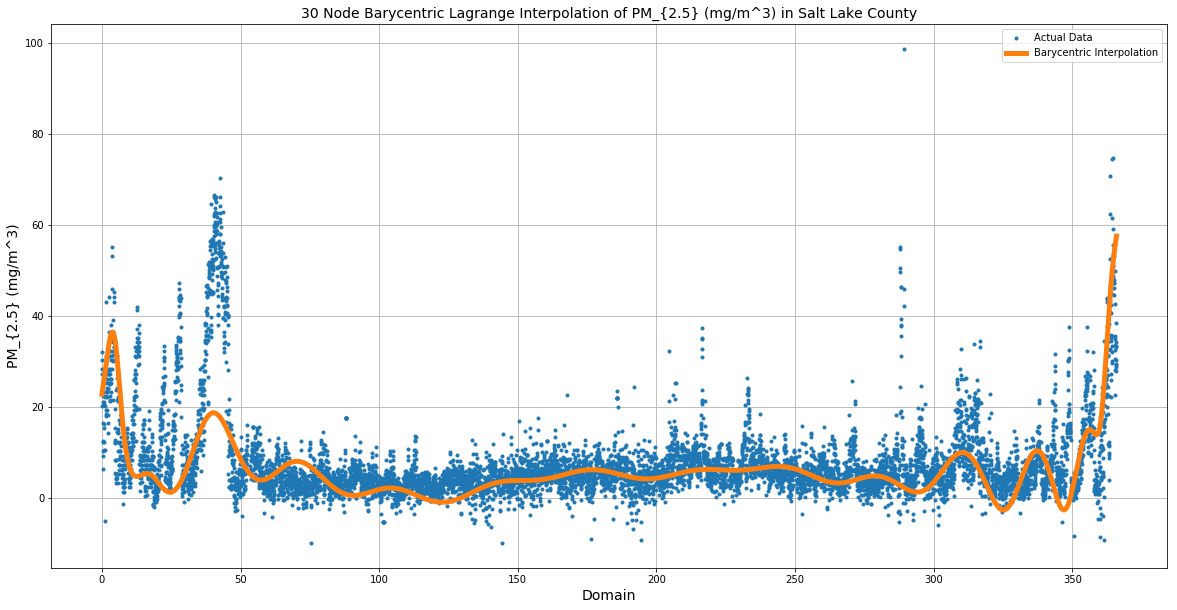

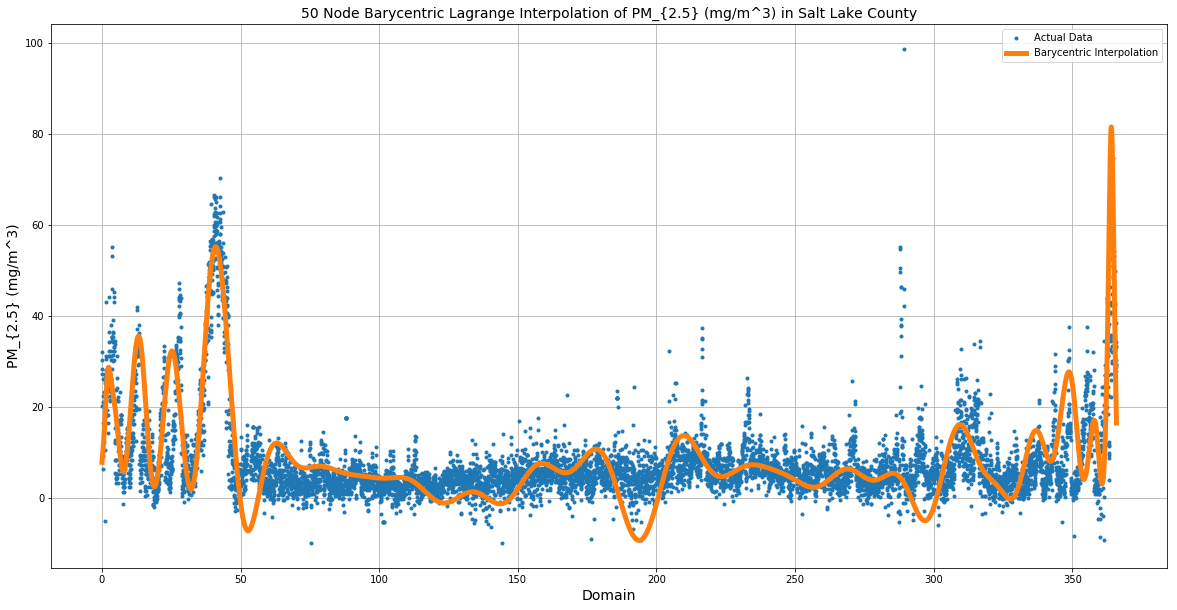

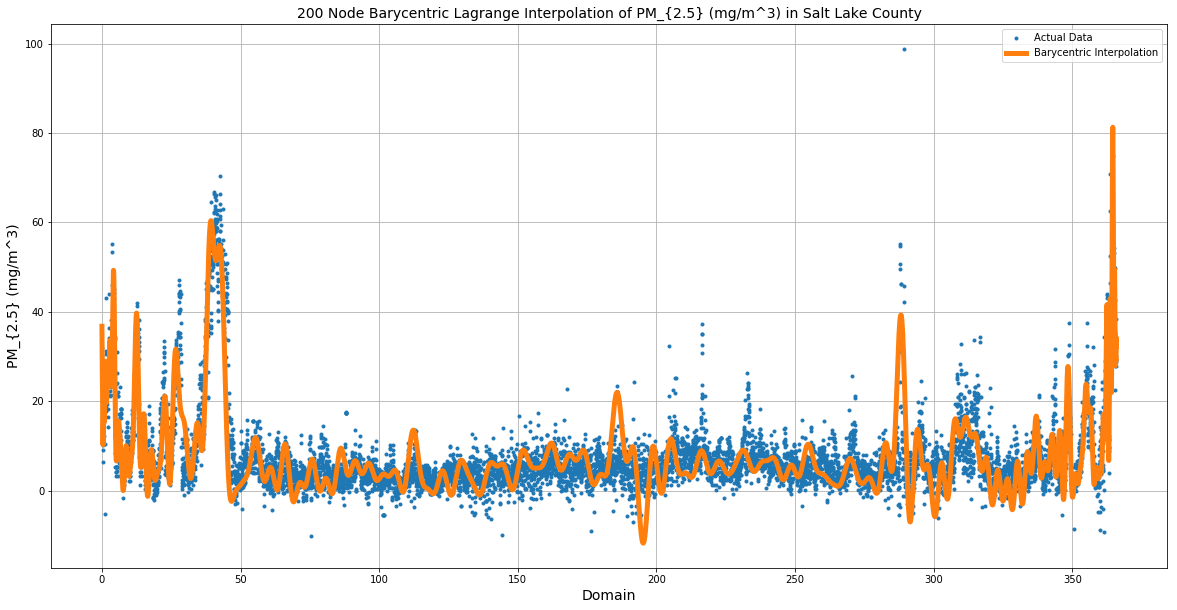

In [25]:
Utah_barycentric(30)
Utah_barycentric(50)
Utah_barycentric(200)

The results are as expected. An interpolation with 30 points is quite inaccurate. An interpolation with 50 points is quite accurate, with most peaks and troughs in the data represented by the interpolating polynomial. The interpolation with 200 points is the most accurate. Attempts to interpolate more than 200 points result in errors.

### Bonus: Error plot

In [26]:
def Utah_barycentric_vals(n):
    fx = lambda a, b, n: .5*(a+b + (b-a) * np.cos(np.arange(n+1) * np.pi / n))
    a, b = 0, 366 - 1/24
    domain = np.linspace(a, b, 8784)
    domainplot = np.copy(domain)
    points = fx(a, b, n)
    temp = np.abs(points - domain.reshape(8784, 1))
    temp2 = np.argmin(temp, axis=0)
    data = np.load("Project 1 Data Files/airdata.npy")
    
    xvals = domain[temp2]
    yvals = data[temp2]
    wherezeros = np.array([], dtype = "int")
    replacement = np.array([])
    numer = np.zeros(8784)
    denom = np.zeros(8784)
    w = Bweights(xvals)
    for jj in range(n-1,0,-1):
        d = (domain - xvals[jj])
        
        z = np.where(np.abs(d)<1e-14)[0] #The following block of code deals with the divisions by zero.
        if len(z) != 0:
            wherezeros = np.append(wherezeros,z)
            replacement = np.append(replacement,yvals[jj])
            domain = np.delete(domain,z)
            d = np.delete(d,z)
            numer = np.delete(numer,z)
            denom = np.delete(denom,z)
        
        numer += (w[jj]*yvals[jj])/d
        denom += (w[jj])/d
    ans = numer/denom
    ans = np.insert(ans,wherezeros,replacement)
    return ans

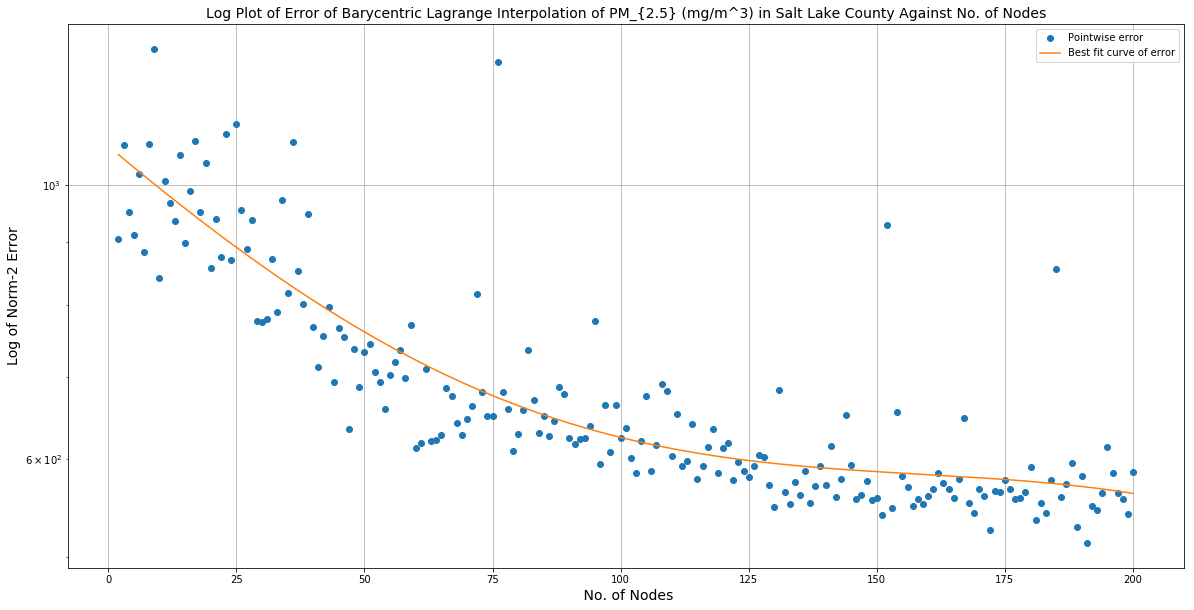

In [27]:
data = np.load("Project 1 Data Files/airdata.npy")
n = 200
Error = np.empty(n-1)
for ii in rangeE(2,n): #May take about half a minute.
    Error[ii-2] = np.linalg.norm((Utah_barycentric_vals(ii) - data), ord=2)

plt.figure(figsize=(20,10))
plt.title('Log Plot of Error of Barycentric Lagrange Interpolation of PM_{2.5} (mg/m^3) in Salt Lake County Against No. of Nodes', fontsize = 14)
plt.xlabel(" No. of Nodes", fontsize = 14)
plt.ylabel("Log of Norm-2 Error", fontsize = 14)
plt.semilogy(rangeE(2,n),Error,'o')
plt.semilogy(rangeE(2,n),np.polynomial.polynomial.Polynomial.fit(rangeE(2,n),Error,deg=3)(rangeE(2,n)))
plt.legend(["Pointwise error","Best fit curve of error"])
plt.grid()

As would be expected (since we are using Chebyshev points), the error of the interpolation decreases as the number of nodes increases. Though the decrease is quite messy pointwise, the overall pattern (as indicated by the best fit curve) is highly reminiscent of the Log Error Plot in Problem 5, which was re-plotted below for reference. The shape of the error plots resemble that of the graph of $\displaystyle\frac{1}{x}$, though the latter has too few plot points for us to be confident of its exact shape.

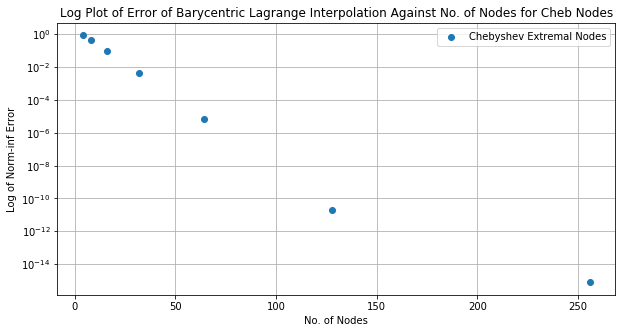

In [28]:
Mx = 8
Mn = 2
f = lambda x: 1/(1+25 * x**2)
chebval = np.empty(Mx - Mn + 1)
x = np.empty(Mx - Mn + 1)

for n in rangeE(Mn,Mx): #Use 2^n nodes.
    linval[n-2] = InterpolErr_ScB(f,n,lin=True)
    chebval[n-2] = InterpolErr_ScB(f,n,lin=False)
    x[n-2] = 2**n

plt.figure(figsize=(10,5))
plt.semilogy(x, chebval, 'o')
plt.xlabel("No. of Nodes")
plt.ylabel("Log of Norm-inf Error")
plt.title("Log Plot of Error of Barycentric Lagrange Interpolation Against No. of Nodes for Cheb Nodes")
plt.legend(["Chebyshev Extremal Nodes"])
plt.grid()

This is a re-plot of the Log Error Plot from Problem 5 for reference.

## Problem 8

Conditions:
$f$ is twice integrable, and 
$$\int_a^b f(x) dx = u'(b) - u'(a) = \beta - \alpha.$$

## Problem 9

### Plot of Data Points:

[0.77858578 1.45727016 1.57460507 1.40420325 1.30229431 1.24006317
 1.02113307 0.5432965  0.31451772 0.10474462 0.12026774 0.30348686]


Text(0.5, 1.0, 'Plot of Data Points')

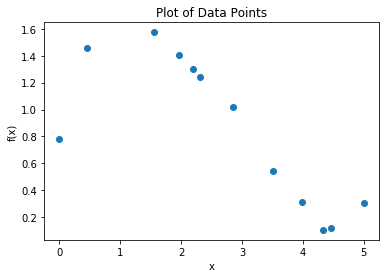

In [29]:
data = np.load("Project 1 Data Files/heatdatanew.npy")
xvals = data[0,:]
fvals = data[1,:]
print(fvals)
plt.plot(xvals,fvals,'o')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Plot of Data Points")

We can see that the data points are not equispaced, or for that matter, spaced like Chebyshev points.

Using results from Q3 of Homework 3, we will cast the problem into the form $A\vec{U} = \vec{G}$ using the finite difference formula,
$$u''(x) = \frac{1}{h^2}u(x-h) - \frac{2}{h^2}u(x) + \frac{1}{h^2}u(x+h).$$

$$\therefore A = \frac{1}{h^2}\left(
\begin{array}{ccccccccc}
-2 & 1 & 0 & 0 & 0 & \ldots & 0 & 0 & 0\\
 1 & -2 & 1 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 & 1 & -2 & 1 & 0 & \ldots & 0 & 0 & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
 0 & 0 & 0 & 0 & 0 &\ldots & 1 & -2 & 1 \\
 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 1 & -2
 \end{array} \right) \hspace{2pc}
 \vec{U} = \left(
 \begin{array}{c}
 u(x_1) \\
 u(x_2) \\
 \vdots \\
 u(x_n)
 \end{array} \right) \hspace{2pc}
 \vec{G} = \left(
 \begin{array}{c}
 u''(x_1) - \displaystyle \frac{1}{h^2}u(x_0) \\
 u''(x_2) \\
 \vdots \\
 u''(x_{n-1}) \\
 u''(x_n) - \displaystyle \frac{1}{h^2}u(x_{n+1})
 \end{array} \right)$$

Note that $u(x_{n+1}) = u(b) = \beta = 5.250$.

Approximating $u'(x_0) = u'(a) = \alpha$ using the forward difference method, we get,
$$u'(a) = \frac{u(x_1) - u(a)}{h} \implies u(a) = u(x_1) - hu'(a).$$

Therefore, the first equation of the linear system $A\vec{U} = \vec{G}$ is
 \begin{align}
 &\frac{-2u(x_1) + u(x_2)}{h^2} = u''(x_1) - \frac{1}{h^2}u(a) \\
 &\implies \frac{-2u(x_1) + u(x_2)}{h^2} = u''(x_1) - \frac{1}{h^2}(u(x_1) - hu'(a)) \\
 &\implies \frac{-u(x_1) + u(x_2)}{h^2} = u''(x_1) + \frac{1}{h}u'(a) \\
 &\implies \frac{-u(x_1) + u(x_2)}{h^2} = u''(x_1) + \frac{\alpha}{h}.
 \end{align}
 
 Therefore, we get
 $$A = \frac{1}{h^2}\left(
\begin{array}{ccccccccc}
 -1 & 1 & 0 & 0 & 0 & \ldots & 0 & 0 & 0\\
 1 & -2 & 1 & 0 & 0 & \ldots & 0 & 0 & 0\\
 0 & 1 & -2 & 1 & 0 & \ldots & 0 & 0 & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
 0 & 0 & 0 & 0 & 0 &\ldots & 1 & -2 & 1 \\
 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 1 & -2
 \end{array} \right) \hspace{2pc}
 \vec{U} = \left(
 \begin{array}{c}
 u(x_1) \\
 u(x_2) \\
 \vdots \\
 u(x_n)
 \end{array} \right) \hspace{2pc}
 \vec{G} = \left(
 \begin{array}{c}
 \displaystyle u''(x_1) + \frac{\alpha}{h} \\
 u''(x_2) \\
 \vdots \\
 u''(x_{n-1}) \\
 u''(x_n) - \displaystyle \frac{\beta}{h^2}
 \end{array} \right)$$

The problem we face however, is that the approach above assumes that we have equispaced data points, and hence $h$ is a constant. The graph of the data points makes it evident that this is not true. To make up for our data points not being equispaced, we will need to interpolate them.

### Barycentric Lagrange Interpolation

We can just directly interpolate the data points using Scipy's BarycentricInterpolator:

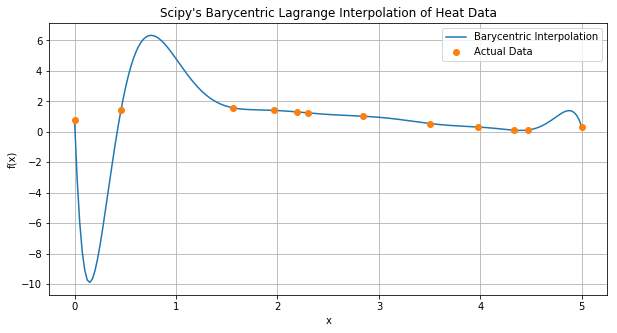

In [30]:
plt.figure(figsize=(10,5))
x = np.linspace(0,5,200)
plt.title("Scipy's Barycentric Lagrange Interpolation of Heat Data")
poly = BarycentricInterpolator(xvals,fvals)

plt.plot(x,poly.__call__(x))
plt.plot(xvals,fvals,"o")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(["Barycentric Interpolation","Actual Data"])
plt.grid()

However, the error of the interpolation will most likely be horrendous due to the high degree of the interpolating polynomial and the large $x$-distance between certain data points, especially between the two leftmost points.

### Cubic Spline Interpolation

In [31]:
def cubic_spline_coeffs(xvals,yvals):

    n = xvals.size - 1
    h = xvals[1:]-xvals[0:-1]

    d0 = np.hstack([1,2*(h[0:-1]+h[1:]),1])
    d1 = np.hstack([0,h[1:]])
    dm1 = np.hstack([h[0:-1],0])
    # create the "A" matrix by using the np.diag command
    A = np.diag(d0) + np.diag(d1,1)+ np.diag(dm1,-1)

    
    # create the right-hand-side of A*x = b
    # recall that a_j = y_j
    aVec = yvals
    rhs = np.hstack([0,(3./h[1:])*(aVec[2:]-aVec[1:-1])-(3/h[0:-1])*(aVec[1:-1]-aVec[0:-2]),0])
    
    # use the linalg.solve command to solve Ax = b  
    cVec = np.linalg.solve(A,rhs)

    
    # use the remaining formula to determine d_j and b_j
    dVec = (cVec[1:]-cVec[0:-1])/(3*h)
    bVec = 1/h*(aVec[1:] - aVec[0:-1]) - h/3*(2*cVec[0:-1]+cVec[1:])
    
    # stack all of the coefficients into a matrix so that the coefficients are in the form 
    #            a_0, a_1, ...
    #            b_0, b_1, ...
    #            c_0, c_1, ...
    #            d_0, d_1, ...
    
    SCoeffs = np.vstack([aVec[0:n], bVec[0:n], cVec[0:n], dVec[0:n]])
    return SCoeffs

def cubic_spline_f(x, coeffs, xvals):
    n = len(coeffs[0])
    ans = 0
    for ii in range(0,4):
        for jj in range(0,n):
            ans += coeffs[ii][jj]*((x-xvals[jj])**ii)*((xvals[jj]<x) and (x<=xvals[jj+1]))
    return ans

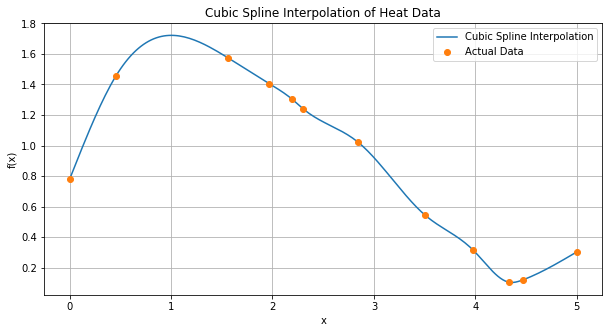

In [32]:
x = np.linspace(1e-14,5,200) #We don't start exactly at zero to avoid a point (0,0) in the cubic spline interpolation.
n = len(x)
poly = np.empty(n)
for i in range(0,n):
    poly[i] = cubic_spline_f(x[i],cubic_spline_coeffs(xvals,fvals),xvals)

    
plt.figure(figsize=(10,5))
plt.title("Cubic Spline Interpolation of Heat Data")
plt.plot(x,poly)
plt.plot(xvals,fvals,"o")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(["Cubic Spline Interpolation","Actual Data"])
plt.grid()

The cubic spline interpolation produces a far more believable interpolation of the data points.

### Best Fit Polynomials

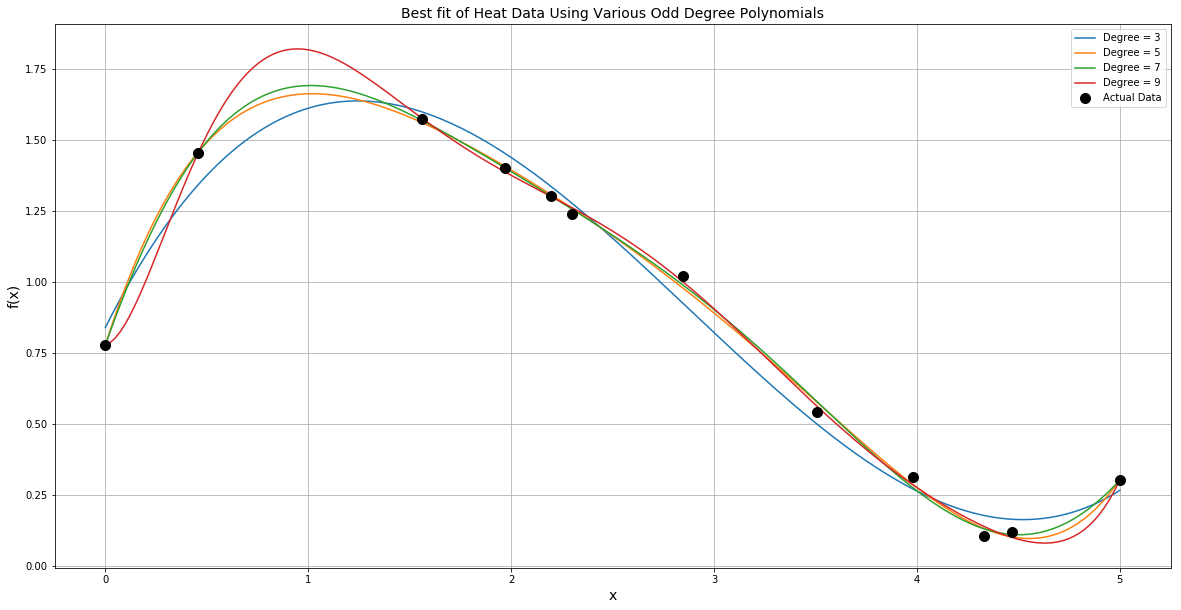

In [33]:
x = np.linspace(0,5,200)
poly3 = np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=3)(x)
poly5 = np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=5)(x)
poly7 = np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=7)(x)
poly9 = np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=9)(x)

plt.figure(figsize=(20,10))
plt.title("Best fit of Heat Data Using Various Odd Degree Polynomials", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("f(x)", fontsize = 14)
plt.plot(x,poly3)
plt.plot(x,poly5)
plt.plot(x,poly7)
plt.plot(x,poly9)
plt.plot(xvals,fvals,"o",color="black", markersize = 10)
plt.legend(["Degree = 3","Degree = 5", "Degree = 7", "Degree = 9", "Actual Data"])
plt.grid()

With the best fit polynomials, we need to search for a balance between higher degrees providing greater pointwise accuracy (with regard to our data points) and lower degrees minimising the oscillation between data points. We used odd degrees due to the "N" shape of our data points.

From the plot, we will choose the degree $7$ polynomial (green curve) as that which strikes the best balance.

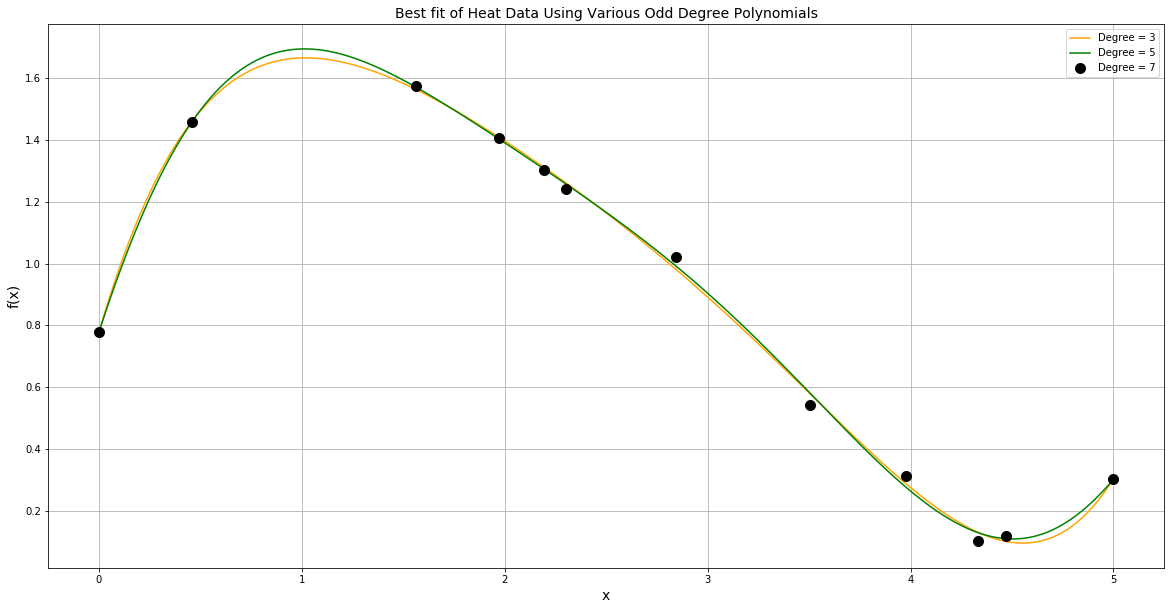

In [34]:
x = np.linspace(0,5,200)

plt.figure(figsize=(20,10))
plt.title("Best fit of Heat Data Using Various Odd Degree Polynomials", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("f(x)", fontsize = 14)
plt.plot(x,poly5, color="orange")
plt.plot(x,poly7, color="green")
plt.plot(xvals,fvals,"o",color="black", markersize = 10)
plt.legend(["Degree = 3","Degree = 5", "Degree = 7", "Degree = 9", "Actual Data"])
plt.grid()

In [35]:
print("Euclidean norm error of the degree 5 polynomial is",np.linalg.norm((np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=5)(xvals) - fvals),ord=2))
print("Euclidean norm error of the degree 7 polynomial is",np.linalg.norm((np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=7)(xvals) - fvals),ord=2))

Euclidean norm error of the degree 5 polynomial is 0.07258835745203708
Euclidean norm error of the degree 7 polynomial is 0.06937707057378499


Both the degree $5$ and degree $7$ best-fit polynomials provide high pointwise accuracy while not having any noticeable oscillations between points. We chose the degree $7$ best-fit polynomial since it provides greater pointwise accuracy as evidenced by the error measurements.

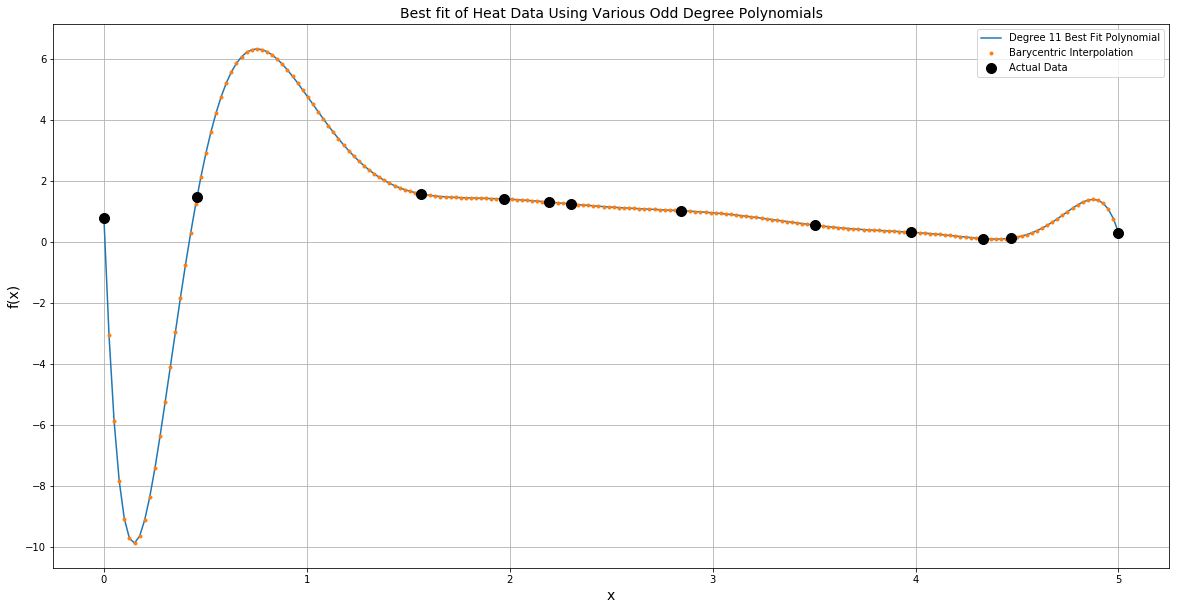

In [36]:
x = np.linspace(0,5,200)
poly11 = np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=11)(x)
poly = BarycentricInterpolator(xvals,fvals)

plt.figure(figsize=(20,10))
plt.title("Best fit of Heat Data Using Various Odd Degree Polynomials", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("f(x)", fontsize = 14)
plt.plot(x,poly11)
plt.plot(x,poly.__call__(x),'.')
plt.plot(xvals,fvals,"o",color="black", markersize = 10)
plt.legend(["Degree 11 Best Fit Polynomial","Barycentric Interpolation","Actual Data"])
plt.grid()

Note that a degree $11$ "best fit" polynomial will interpolate our data points perfectly; the result is identical to the Barycentric Langrange Interpolation of our data points.

### Solving the PDE using different interpolations

In [37]:
def solve_for_U(xvals,uppvals): #Code taken from HW3 and edited.
    h = xvals[2:]-xvals[1:-1] #We assume that the points are equispaced.
    d0 = -2/h**2
    d0[0] = -1/h[0]**2 #This accounts for the Neumann Boundary Condition.
    d1 = 1/h[1:]**2
    dm1 = 1/h[0:-1]**2
    # create the "A" matrix by using the np.diag command
    A = sp.diags(d0) + sp.diags(d1,1)+ sp.diags(dm1,-1)
    
    # Ax = b, solve for x.
    uvals = spsolve(A,uppvals) #I'm using scipy sparse matrice solver else I'll run into memory problems later.
    
    return uvals

In [38]:
x = np.linspace(1e-14,5,1000) #We don't start exactly at zero to avoid a point (0,0) in the cubic spline interpolation.
n = len(x)
h = np.abs(x[1] - x[0])
alpha = 0.416
beta = 5.250

#Define vector G for different interpolations:
uppbary = BarycentricInterpolator(xvals,fvals).__call__(x[1:(n-1)])
uppbary[0] = uppbary[0] + alpha/h
uppbary[n-3] = uppbary[0] - beta/h**2

uppCS = np.empty(n-2)
for i in range(0,n-3):
    uppCS[i] = cubic_spline_f(x[i],cubic_spline_coeffs(xvals,fvals),xvals)
uppCS[0] = uppCS[0] + alpha/h
uppCS[n-3] = uppCS[0] - beta/h**2

uppBF = np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=7)(x[1:(n-1)])
uppBF[0] = uppBF[0] + alpha/h
uppBF[n-3] = uppBF[0] - beta/h**2

solbary = solve_for_U(x,uppbary)
solCS = solve_for_U(x,uppCS)
solBF = solve_for_U(x,uppBF)

In [39]:
def appendBC(sol): #This function simply makes it easier to append the boundary conditions.
    u_0, u_n = sol[0] - h*alpha, beta #Boundary conditions
    return (np.insert((np.insert(sol,len(sol),u_n)),0,u_0)) #Add u_0 and u_n into yvals.

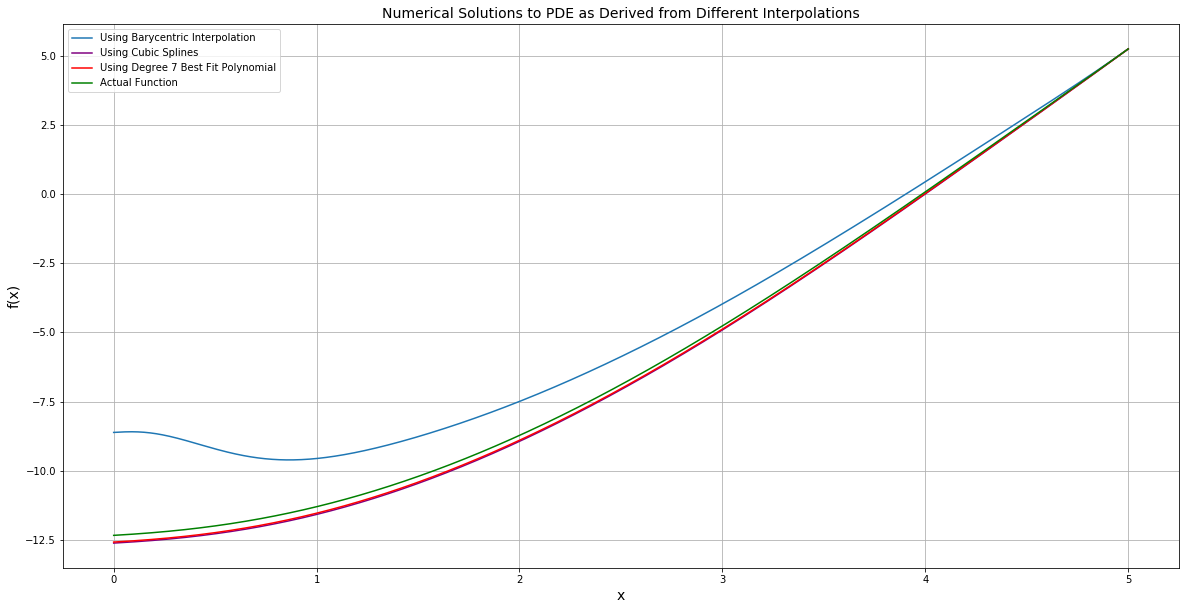

In [40]:
u = lambda x: 0.00024381*x**7 - 0.00426667*x**6 + 0.032*x**5 - 0.141667*x**4 + 1/3*x**3 + 0.4*x**2 + 0.416*x -12.3357
#This is the actual function, solved analytically with the help of WolframAlpha.
#Note that actual f(x) = (2/5*x - 1)**5 - x**2/10 + 1.8

plt.figure(figsize=(20,10))
plt.title("Numerical Solutions to PDE as Derived from Different Interpolations", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("f(x)", fontsize = 14)
plt.plot(x,appendBC(solbary))
plt.plot(x,appendBC(solCS),color="purple")
plt.plot(x,appendBC(solBF),color="red")
plt.plot(x,u(x), color="green")
plt.legend(["Using Barycentric Interpolation","Using Cubic Splines","Using Degree 7 Best Fit Polynomial","Actual Function"])
plt.grid()

 As expected, the Barycentric Interpolation was extremely inaccurate and that inaccuracy was brought forward into the numerical solution derived from it. Otherwise, both the cubic spline and degree $7$ best fit polynomial resulted in pretty accurate estimates of the actual solution. The most significant inaccuracy is at the leftmost boundary point. That inaccuracy is most likely due to the fact that forward difference is a very inaccurate method for approximating $u'$, hence, the $u(a)$ value (left Neumann boundary condition) we derived is inaccurate.

### Error Analysis (ignoring the Barycentric Interpolation method since it is blatantly inaccurate)

In [41]:
print("Norm-inf error of Cubic Spline method is", np.linalg.norm(f(x)-appendBC(solCS),ord=np.inf))
print("Norm-inf error of Best Fit Poly method is", np.linalg.norm(f(x)-appendBC(solBF),ord=np.inf))

Norm-inf error of Cubic Spline method is 13.61535574364069
Norm-inf error of Best Fit Poly method is 13.577672863134639


As shown by the norm-inf errors, the degree $7$ Best Fit Polynomial method produces the most accurate numerical solution.

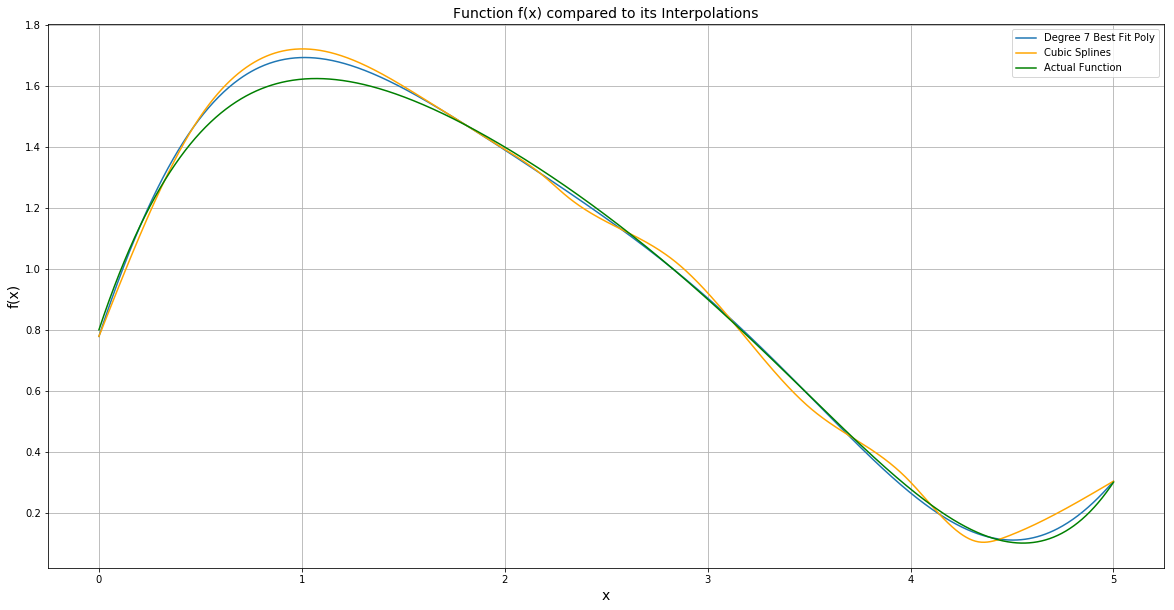

In [42]:
x = np.linspace(1e-14,5,1000)

f = lambda x: (2/5*x - 1)**5 - x**2/10 + 1.8
poly = np.empty(n)
for i in range(0,n):
    poly[i] = cubic_spline_f(x[i],cubic_spline_coeffs(xvals,fvals),xvals)

plt.figure(figsize=(20,10))
plt.title("Function f(x) compared to its Interpolations", fontsize = 14)
plt.xlabel("x", fontsize = 14)
plt.ylabel("f(x)", fontsize = 14)
plt.plot(x,np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=7)(x))
plt.plot(x,poly,color="orange")
plt.plot(x,f(x), color="green")
plt.legend(["Degree 7 Best Fit Poly","Cubic Splines","Actual Function"])
plt.grid()

The graphs show that the degree $7$ best fit polynomial interpolates the function $f(x)$ the best, which is probably why it ultimately produces the most accurate numerical solution.

In [43]:
x = np.linspace(1e-14,5,10000) #We don't start exactly at zero to avoid a point (0,0) in the cubic spline interpolation.
n = len(x)
h = np.abs(x[1] - x[0])
alpha = 0.416
beta = 5.250

#Define vector G for different interpolations:
uppCS = np.empty(n-2)
for i in range(0,n-3):
    uppCS[i] = cubic_spline_f(x[i],cubic_spline_coeffs(xvals,fvals),xvals)
uppCS[0] = uppCS[0] + alpha/h
uppCS[n-3] = uppCS[0] - beta/h**2

uppBF = np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=7)(x[1:(n-1)])
uppBF[0] = uppBF[0] + alpha/h
uppBF[n-3] = uppBF[0] - beta/h**2

solCS = solve_for_U(x,uppCS)
solBF = solve_for_U(x,uppBF)

In [44]:
print("Norm-inf error of Cubic Spline method for 10000 points is", np.linalg.norm(f(x)-appendBC(solCS),ord=np.inf))
print("Norm-inf norm error of Best Fit Poly method for 10000 points is", np.linalg.norm(f(x)-appendBC(solBF),ord=np.inf))

Norm-inf error of Cubic Spline method for 10000 points is 13.747251863678338
Norm-inf norm error of Best Fit Poly method for 10000 points is 13.703092475264455


Even with a lot more points used ($10000$ as compared to the original $1000$), the norm-inf error barely changed. This supports the hypothesis that the inaccuracy of the numerical solution can largely be attributed to the inaccuracy of the estimation of the left boundary condition. This also indicates that the numerical solution produced by each method converges as the number of points used tends to infinity (though the numerical solution does not necessarily converge to the actual solution).

### Runtime Analysis

Since the solve_for_u function is identical for all three methods, the difference in runtime for each method is determined by the time it takes to perform the interpolation. We will compare the time it takes for each method to start from scratch and output an estimate of a function at a point.

In [45]:
x = np.random.rand(1)[0] + 1

%timeit uppbary = BarycentricInterpolator(xvals,fvals).__call__(x)
%timeit cubic_spline_f(x,cubic_spline_coeffs(xvals,fvals),xvals)
%timeit np.polynomial.polynomial.Polynomial.fit(xvals,fvals,deg=7)(x)

195 µs ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
386 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
308 µs ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


From the time trials, it can be seen that Barycentric Lagrange Interpolation is the fastest. Cubic Spline Interpolation is slightly slower than creating the degree $7$ Best Fit Polynomial. Though it should be noted that cubic_spline_f has a lot more potential for optimisation as it is a homebrewed function whereas np.polynomial.polynomial.Polynomial.fit is a Numpy function.

### Conclusion

For this PDE, the cubic spline and best fit polynomial methods are very comparable in terms of accuracy and runtime. However, it should be noted that we had to examine the shape of the data and experiment with different degrees to decide that a degree $7$ polynomial works well. Choosing a different degree for our best fit polynomial can have an adverse impact on the accuracy of that method.

Balancing between accuracy, runtime and versatility, for an arbitrary PDE, the cubic spline method is the most promising.

In any case, the largest improvement which can be made over the methods employed for this PDE is to find a way to better estimate $u'$.